# Generating Art with Deep Learning
This Notebook shows how to use a pretrained network, to generate art of a choosen style. Heavily inspired by [Siraj Raval](https://www.youtube.com/watch?v=Oex0eWoU7AQ&t=234s).

## Notebook Content
1. [Introduction](#1)
     1. [Import](#11)
     2. [Get the Pictures](#12)
     3. [Preprocessing of the pictures](#13)
2. [Generate Art](#2)
    1. [Using a pretrained Network](#21)
    2. [Content loss](#22)
    3. [Style loss](#23)
    4. [Total variation loss](#24)
    5. [Solving the problem](#25)
3. [Conclusion](#3)
    

<a id="1"></a>
## 1.0 Introduction
This Notebook shows the usage of VGG16 and two pictures, to create a whole new picture. The Neural Network tries to incorperate the style of one picture into the other, while trying to minimize the differences between the two pictures. This deep learning project gives a glance at what is possible with neural networks.

<a id="11"></a>
### 1.1 Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

['berlin', 'images', 'vgg16data', 'vgg16', 'styles']


Importing the things we need for our project, including the pretrained network called VGG16.

In [2]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


<a id="12"></a>
### 1.2 Get the pictures

First, lets define the size of the pictures we want

In [3]:
height = 512
width = 512


Now read both pictures, resize them accordingly and take at look at them to make sure we did everything right

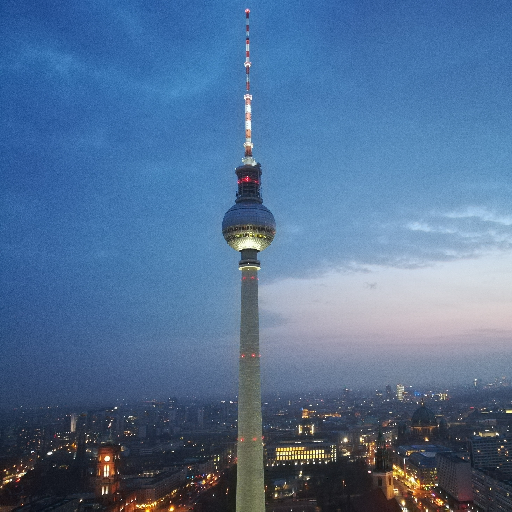

In [4]:
content_image = Image.open("../input/berlin/berlin.jpg")
content_image = content_image.resize((height, width))
content_image

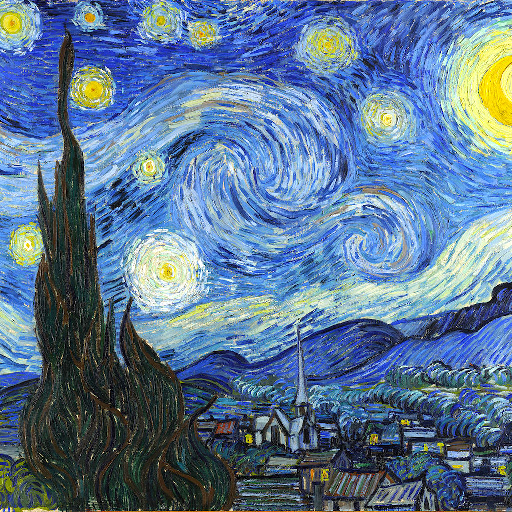

In [5]:
style_image = Image.open("../input/styles/starry_night.jpg")
style_image = style_image.resize((height, width))
style_image

<a id="13"></a>
### 1.3 Preprocessing of the pictures

Create another dimension to be able to concatenate the representations of those two images into a common data structure later on

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


According to [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556) we need to "massage" the input data to use it for the VGG Network model we want to use.

We will perform two transformations:
1. Subtract the mean RGB value from each pixel (easily found with google)
2. Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper)

In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we can use these arrays to define variables in Keras' backend (TensorFlow graph). Also, we are creating a placeholder variable which will store the combination image.

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Instructions for updating:
Colocations handled automatically by placer.


Now, we concatenate all the data into a single tensor which is usable by Keras' VGG16 model.

In [9]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

<a id="2"></a>
## 2. Generating Art

<a id="21"></a>
### 2.1 Using a pretrained Neural Network
The core idea which was introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the feature spaces provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), but we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer model (VGG), because there is no noticeable qualititave difference in making this choice and the smaller one is faster to train.

Also, since we're actually not interested in the classification problem, we don't need the fully connected layers of the final softmax classifier. 

Luckily it is trivial for us to get the access to the truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting 'include_top=False' in the code below, we don't include any of the fully connected layers.

In [10]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


The model we're using has a lot of layers, lets make a list of them to be able to refer to them later on if needed.

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

The crux of the paper we're trying to reproduce is that the [style transfer problem can be posed as an optimisation problem](https://harishnarayanan.org/writing/artistic-style-transfer/), where the loss function we want to minimise can be decomposed into three distinct parts: the content loss, the style loss and the total variation loss.

The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates otuput that's aesthetically pleasing. 

In [12]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss at 0 and adding to it in stages.

In [13]:
loss = backend.variable(0.)

<a id="22"></a>
### 2.2 Content loss
For the content loss, we follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) again and draw the content feature from block2_conv2, because the original choice in [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) loses too much structual detail, which will deform faces too much.

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

<a id="23"></a>
### 2.3 Style loss
This is where things start to get a bit intricate.

For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content (this is very complicated and explained further in [another paper](https://arxiv.org/abs/1606.01286) ).

The gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [15]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

Again, in the following code, the style features are from [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) rather than [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576).

In [16]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

<a id="24"></a>
### 2.4 Total variation loss
This one is simpler again.

If you were to solve the optimisation problem with only the two loss terms introduced so far, you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](https://arxiv.org/abs/1412.0035) that encourages spatial smoothness.

You can experiment with reducing the *total_variation_weight* and play with the noise-level of the generated image.

In [17]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

<a id="25"></a>
### 2.5 Define needed gradients and solve the optimisation problem
The goal of this journey was to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while have the style of the style image. Now that we have our imput images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

We start by defining the gradients.

In [18]:
grads = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two seperate functions, *loss* and *grads*. This is done because *scipy.optimize* requires seperate functions for loss and gradients, but computing them sepearatly would be inefficient. 

In [19]:

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it. 

We stop after 10 iterations because the output looks good and the loss stops reducing significantly.

In [20]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 123622460000.0
Iteration 0 completed in 311s
Start of iteration 1
Current loss value: 67046840000.0
Iteration 1 completed in 322s
Start of iteration 2
Current loss value: 54693347000.0
Iteration 2 completed in 307s
Start of iteration 3
Current loss value: 50795130000.0
Iteration 3 completed in 307s
Start of iteration 4
Current loss value: 48785540000.0
Iteration 4 completed in 306s
Start of iteration 5
Current loss value: 47407464000.0
Iteration 5 completed in 306s
Start of iteration 6
Current loss value: 46422786000.0
Iteration 6 completed in 308s
Start of iteration 7
Current loss value: 45448274000.0
Iteration 7 completed in 309s
Start of iteration 8
Current loss value: 44855620000.0
Iteration 8 completed in 307s
Start of iteration 9
Current loss value: 44459295000.0
Iteration 9 completed in 308s


This calculation took a while for me, around 6 Minutes per iteration for a total of 60 Minutes for one picture. For the final result we need to subject our output image to the inverse of the transformation we did to our input image before it makes sense.

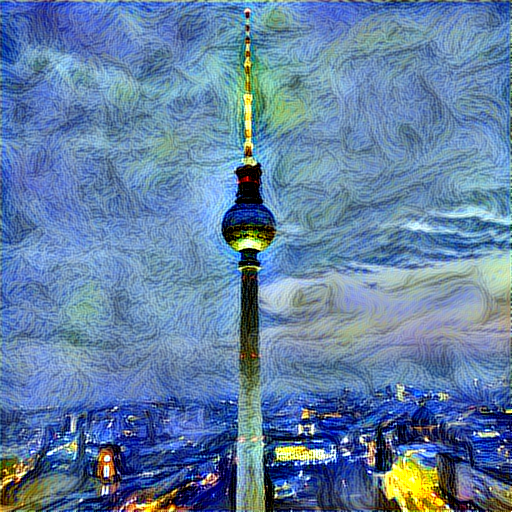

In [21]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

<a id="3"></a>
## 3. Conclusion
Due to solving an entire optimisation problem each time we generate an image, the process we use is quite slow. Even with the help of GPUs, it is a quite expensive problem to solve. I find it still very impressive, how a neural network can create somthing which you could call art. 